# Twitter Data Analysis and Modeling

importing relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer


importnig processing scripts

In [2]:
from extract_dataframe import read_json         # a function to load json_data 
from extract_dataframe import TweetDfExtractor  # and a class to extract relevant variables.    
from clean_tweets_dataframe import Clean_Tweets        # collection of functions to for cleaning the dataframe.

Loading JSON file, selecting relevant variables, and generating a CSV file.

In [3]:
_, tweet_list = read_json("data/Economic_Twitter_Data.json")
tweet = TweetDfExtractor(tweet_list)
tweet.get_tweet_df(True)  # this will also generate a CSV file.
print("Load the CSV file")

File Successfully Saved.!!!
Load the CSV file


In [4]:
tweet_df = pd.read_csv('processed_tweet_data.csv')  # loads the csv file created above.

## Data Cleaning

In [5]:
cleaner = Clean_Tweets(tweet_df)
tweet_df = cleaner.drop_unwanted_column(tweet_df)
tweet_df = cleaner.drop_duplicate(tweet_df)
tweet_df = cleaner.convert_to_datetime(tweet_df)
tweet_df = cleaner.convert_to_numbers(tweet_df)
clean_tweet_df = cleaner.remove_non_english_tweets(tweet_df)

Automation in Action...!!!


## Data Exploration

In [6]:
clean_tweet_df.info()  # displays basic information about the dataframe like column names and size of df


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16374 entries, 38 to 24622
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          16374 non-null  datetime64[ns, UTC]
 1   source              16374 non-null  object             
 2   original_text       16374 non-null  object             
 3   clean_text          16371 non-null  object             
 4   polarity            16374 non-null  float64            
 5   subjectivity        16374 non-null  float64            
 6   screen_name         16374 non-null  object             
 7   language            16374 non-null  object             
 8   retweet_count       16374 non-null  int64              
 9   friends_count       16374 non-null  int64              
 10  hashtags            16374 non-null  object             
 11  statuses            16374 non-null  int64              
 12  followers_count     16374 non-n

In [7]:
clean_tweet_df.head()  #checking the top 6 rows.

,created_at,source,original_text,clean_text,polarity,subjectivity,screen_name,language,retweet_count,friends_count,hashtags,statuses,followers_count,user_mentions,possibly_sensitive,favourites_count,location
38,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,The 10-year yield is telling us that there's ...,0.16,0.540000,davideiacovozzi,en,43,55,"[{'text': 'gold', 'indices': [116, 121]}, {'te...",281,18,"[{'screen_name': 'NorthstarCharts', 'name': 'N...",NaN,12179,NaN
39,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,…,0.00,0.000000,davideiacovozzi,en,32,55,[],281,18,"[{'screen_name': 'MichaelAArouet', 'name': 'Mi...",NaN,12179,NaN
41,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,//t.co/kO2FfHKaZg,0.00,0.000000,davideiacovozzi,en,26,55,[],281,18,"[{'screen_name': 'goldseek', 'name': 'Peter ⚒ ...",False,12179,NaN
42,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,The 30-year mortgage rate in the US rises to ...,0.00,0.183333,davideiacovozzi,en,213,55,[],281,18,"[{'screen_name': 'charliebilello', 'name': 'Ch...",NaN,12179,NaN
43,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,//t.co/brNJeK3WTb,0.00,0.000000,davideiacovozzi,en,417,55,[],281,18,"[{'screen_name': 'biancoresearch', 'name': 'Ji...",False,12179,NaN


In [23]:
clean_tweet_df = clean_tweet_df[['original_text', 'polarity']] # selecting only the relevant variables for further analysis

In [24]:
clean_tweet_df.shape

(13966, 2)

### creating a new variable: sentiment

In [8]:
def sentiment_group (p): # a function used to represent polarity values in string
  if p > 0:
    return 'positive'
  elif p < 0:
    return 'negative'
  else:
    return 'neutral'

In [9]:
sentiment = pd.Series([sentiment_group(row_val) for row_val in clean_tweet_df['polarity']])

In [10]:
clean_tweet_df = pd.concat([clean_tweet_df, sentiment.rename("sentiment")], axis=1)

### Data Visualization 

Matplotlib is building the font cache; this may take a moment.
C:\Users\IRONMAN\AppData\Local\Temp\ipykernel_5380\389416776.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
C:\Users\IRONMAN\AppData\Local\Temp\ipykernel_5380\389416776.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


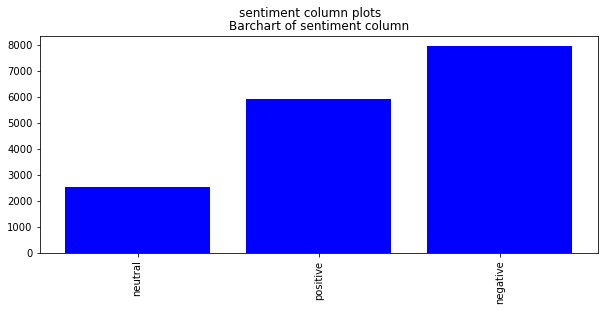

In [12]:

labels = ['neutral', 'positive', 'negative']
positive = len(clean_tweet_df[clean_tweet_df['sentiment'] == "positive"])
negative = len(clean_tweet_df[clean_tweet_df['sentiment'] == "negative"])
neutral = len(clean_tweet_df[clean_tweet_df['sentiment'] == "neutral"])

fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax.bar(x=labels, height=[negative, positive, neutral], color='blue')
ax.set_title('Barchart of sentiment column')
ax.set_xticklabels(labels, rotation=90)

fig.suptitle('sentiment column plots')

fig.show()

In [13]:
clean_tweet_df.groupby('sentiment')['original_text'].count()

sentiment
negative    1675
neutral     5220
positive    3938
Name: original_text, dtype: int64

## Sentiment analysis and modeling

In [14]:
len(clean_tweet_df['polarity'])

21915

In [15]:
clean_tweet_df = clean_tweet_df.drop(clean_tweet_df[clean_tweet_df.sentiment == 'neutral'].index)

In [16]:
clean_tweet_df.head()

,created_at,source,original_text,clean_text,polarity,subjectivity,screen_name,language,retweet_count,friends_count,hashtags,statuses,followers_count,user_mentions,possibly_sensitive,favourites_count,location,sentiment
38,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,The 10-year yield is telling us that there's ...,0.16,0.540000,davideiacovozzi,en,43.0,55.0,"[{'text': 'gold', 'indices': [116, 121]}, {'te...",281.0,18.0,"[{'screen_name': 'NorthstarCharts', 'name': 'N...",NaN,12179.0,NaN,negative
39,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,…,0.00,0.000000,davideiacovozzi,en,32.0,55.0,[],281.0,18.0,"[{'screen_name': 'MichaelAArouet', 'name': 'Mi...",NaN,12179.0,NaN,positive
42,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,The 30-year mortgage rate in the US rises to ...,0.00,0.183333,davideiacovozzi,en,213.0,55.0,[],281.0,18.0,"[{'screen_name': 'charliebilello', 'name': 'Ch...",NaN,12179.0,NaN,positive
43,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,//t.co/brNJeK3WTb,0.00,0.000000,davideiacovozzi,en,417.0,55.0,[],281.0,18.0,"[{'screen_name': 'biancoresearch', 'name': 'Ji...",False,12179.0,NaN,negative
44,2022-04-19 10:59:33+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @LanceRoberts: Buying opportunities like th...,//t.co/cyTVKNXkZD,0.00,0.000000,davideiacovozzi,en,162.0,55.0,"[{'text': 'bonds', 'indices': [78, 84]}]",281.0,18.0,"[{'screen_name': 'LanceRoberts', 'name': 'Lanc...",False,12179.0,NaN,negative


In [17]:
valueArray = pd.Series([1 if row_val == 'positive' else 0 for row_val in clean_tweet_df['sentiment']])

In [19]:
clean_tweet_df['valueArray'] = valueArray

In [20]:
clean_tweet_df.head()

,created_at,source,original_text,clean_text,polarity,subjectivity,screen_name,language,retweet_count,friends_count,hashtags,statuses,followers_count,user_mentions,possibly_sensitive,favourites_count,location,sentiment,valueArray
38,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,The 10-year yield is telling us that there's ...,0.16,0.540000,davideiacovozzi,en,43.0,55.0,"[{'text': 'gold', 'indices': [116, 121]}, {'te...",281.0,18.0,"[{'screen_name': 'NorthstarCharts', 'name': 'N...",NaN,12179.0,NaN,negative,0.0
39,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,…,0.00,0.000000,davideiacovozzi,en,32.0,55.0,[],281.0,18.0,"[{'screen_name': 'MichaelAArouet', 'name': 'Mi...",NaN,12179.0,NaN,positive,0.0
42,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,The 30-year mortgage rate in the US rises to ...,0.00,0.183333,davideiacovozzi,en,213.0,55.0,[],281.0,18.0,"[{'screen_name': 'charliebilello', 'name': 'Ch...",NaN,12179.0,NaN,positive,1.0
43,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,//t.co/brNJeK3WTb,0.00,0.000000,davideiacovozzi,en,417.0,55.0,[],281.0,18.0,"[{'screen_name': 'biancoresearch', 'name': 'Ji...",False,12179.0,NaN,negative,0.0
44,2022-04-19 10:59:33+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @LanceRoberts: Buying opportunities like th...,//t.co/cyTVKNXkZD,0.00,0.000000,davideiacovozzi,en,162.0,55.0,"[{'text': 'bonds', 'indices': [78, 84]}]",281.0,18.0,"[{'screen_name': 'LanceRoberts', 'name': 'Lanc...",False,12179.0,NaN,negative,1.0


In [21]:
X = clean_tweet_df['original_text']
y = clean_tweet_df['valueArray']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

NameError: name 'train_test_split' is not defined

In [ ]:
print(X_train.size)
print(X_test.size)
print(y_train.size)
print(y_test.size)

In [ ]:
count_vect = CountVectorizer(3,3)
X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()

In [ ]:
y_train = y_train.fillna(0)

In [ ]:
# scaling the input
clf = make_pipeline(StandardScaler(),
...                     SGDClassifier(max_iter=9000, tol=1e-2))

In [ ]:
clf.fit(X_train_counts, y_train)

In [ ]:
X_test = X_test.replace(np.nan, '', regex=True)
# use transform not fit_transform
X_test_counts = count_vect.transform(X_test)
X_test_counts = X_test_counts.toarray()
# prediction = clf.prevaluedict(X_test_counts)
prediction = clf.predict(X_test_counts)

In [ ]:
# making prediction
prediction = clf.predict(X_test_counts)

In [ ]:
np.mean(prediction == y_test)